# Return Optimization Training

#### Loading the data

In [7]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import pickle

df = pd.read_csv("return_data.csv")
df.head()

,ASIN,Title,Thumbnail URL,Recent Sales,Manufacturing Date,Price in INR (Extracted Price * 80),Category,Reason,Condition,Days_since_order,Customer_type,Price_range,Action
0,B09GHI0001,Bluetooth Headphones Over-Ear,https://example.com/thumb/bt_headphones.jpg,600,2024-03-10,4000,Electronics,Changed Mind,Like New,7,Returning,Mid,Restock
1,B08JKL1112,Portable Projector Mini,https://example.com/thumb/projector_mini2.jpg,90,2023-11-25,12000,Electronics,Wrong Size,Unopened,20,New,High,Repurpose
2,B07MNO2223,Gaming Monitor 27-inch,https://example.com/thumb/gaming_monitor.jpg,150,2024-01-05,28000,Electronics,Defective,Used,15,VIP,High,Recycle
3,B06PQR3334,Smart TV 4K 55-inch,https://example.com/thumb/smart_tv.jpg,40,2023-09-01,60000,Electronics,Other,Damaged,50,Returning,High,Recycle
4,B05STU4445,Soundbar Wireless,https://example.com/thumb/soundbar.jpg,280,2024-02-18,12000,Electronics,Changed Mind,Unopened,8,New,High,Restock


####  Data Preprocessing


In [8]:
#handling missing values
df.isnull().sum()

ASIN                                   0
Title                                  0
Thumbnail URL                          0
Recent Sales                           0
Manufacturing Date                     0
Price in INR (Extracted Price * 80)    0
Category                               0
Reason                                 0
Condition                              0
Days_since_order                       0
Customer_type                          0
Price_range                            0
Action                                 0
dtype: int64

In [9]:
# correcting the formating
from datetime import datetime

df['Manufacturing Date'] = pd.to_datetime(df['Manufacturing Date'])
df['Product_Age'] = (pd.to_datetime('today') - df['Manufacturing Date']).dt.days


In [10]:
# unnecesary columns
df = df.drop(columns=["ASIN", "Title", "Thumbnail URL", "Manufacturing Date","Recent Sales","Price_range",])

In [11]:
def get_price_range(price):
    if price < 500:
        return "Low"
    elif price < 1500:
        return "Mid"
    else:
        return "High"
df['Price_range'] = df['Price in INR (Extracted Price * 80)'].apply(get_price_range)

In [12]:
df = df.drop(columns=["Price in INR (Extracted Price * 80)"])

In [13]:
# cat to num
df_encoded = pd.get_dummies(df, columns=[
    'Category', 'Reason', 'Condition', 'Customer_type', 'Price_range'
])


In [14]:
df.head()

,Category,Reason,Condition,Days_since_order,Customer_type,Action,Product_Age,Price_range
0,Electronics,Changed Mind,Like New,7,Returning,Restock,491,High
1,Electronics,Wrong Size,Unopened,20,New,Repurpose,597,High
2,Electronics,Defective,Used,15,VIP,Recycle,556,High
3,Electronics,Other,Damaged,50,Returning,Recycle,682,High
4,Electronics,Changed Mind,Unopened,8,New,Restock,512,High


In [15]:
# saving expected columns
import joblib
expected_columns = df_encoded.drop(columns=['Action']).columns.tolist()
joblib.dump(expected_columns, 'expected_columns.pkl')

['expected_columns.pkl']

#### Splitting the features (X) and labels (Y)

In [16]:
X = df_encoded.drop(columns=["Action"])
y = df_encoded["Action"]

In [17]:
y.unique()

array(['Restock', 'Repurpose', 'Recycle', 'Reship'], dtype=object)

In [18]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(y)

In [19]:
df.head()

,Category,Reason,Condition,Days_since_order,Customer_type,Action,Product_Age,Price_range
0,Electronics,Changed Mind,Like New,7,Returning,Restock,491,High
1,Electronics,Wrong Size,Unopened,20,New,Repurpose,597,High
2,Electronics,Defective,Used,15,VIP,Recycle,556,High
3,Electronics,Other,Damaged,50,Returning,Recycle,682,High
4,Electronics,Changed Mind,Unopened,8,New,Restock,512,High


#### Train test split

In [20]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report


X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state=42)
print("Test: ", len(X_test))
print("Train: ",len(X_train))

Test:  97
Train:  384


#### Training the model

In [21]:
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss',max_depth=4,learning_rate=0.1)
model.fit(X_train, y_train)

/Users/akshu/Documents/CODES/Projects/Walmart/.conda/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:07:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

#### Accuracy

In [22]:
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.7628865979381443
              precision    recall  f1-score   support

           0       0.89      0.97      0.93        32
           1       0.69      0.67      0.68        27
           2       0.50      0.50      0.50        16
           3       0.85      0.77      0.81        22

    accuracy                           0.76        97
   macro avg       0.73      0.73      0.73        97
weighted avg       0.76      0.76      0.76        97



#### Confusion Matrix

Text(95.72222222222221, 0.5, 'Truth')

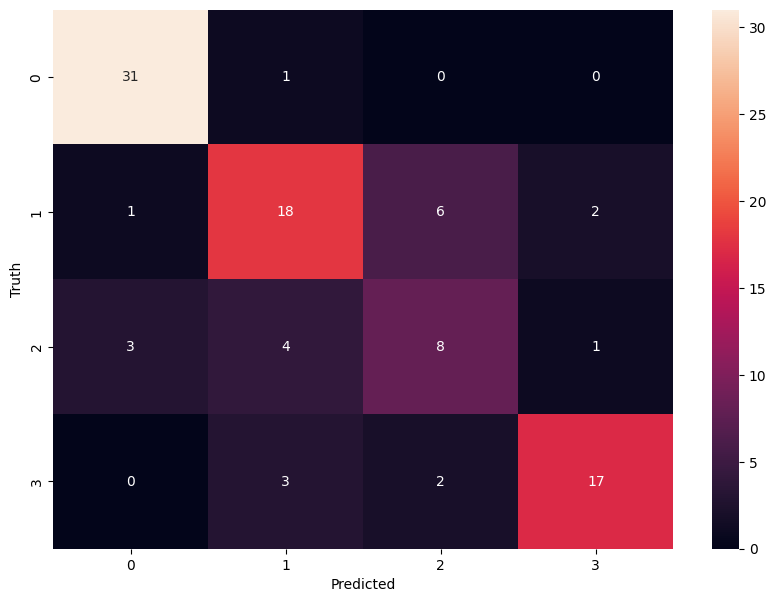

In [23]:
y_predicted = model.predict(X_test)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,y_predicted)
import matplotlib.pyplot as plt
import seaborn as sn
plt.figure(figsize=(10,7))
sn.heatmap(cm,annot = True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [24]:
# --- 9. Confidence Scores ---
import numpy as np

probs = model.predict_proba(X_test)
confidences = probs.max(axis=1)

confident_preds = np.where(confidences > 0.8, y_pred, -1)
print("\n🔐 Predictions with Confidence > 80% (others marked -1):")
print(confident_preds[:10])


🔐 Predictions with Confidence > 80% (others marked -1):
[ 2  1 -1  0  0  2  1 -1 -1 -1]


In [25]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"✅ Accuracy: {accuracy:.4f}")

✅ Accuracy: 0.7629


#### Save the Model ---


In [26]:
import joblib
joblib.dump(le,'label_encoder.pkl')
joblib.dump(model, "xgb_classifier_model.pkl")
print("Bruh...")

Bruh...
